# Kaggle Facial Keypoint DetectionをKerasで実装

In [1]:
# 各種モジュールのimport
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

## データ準備

In [2]:
# training dataとtest dataの定義
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'

In [3]:
# データのload用関数
def load(test=False, cols=None):
    """
    testがTrueの場合はFTESTからデータを読み込み、Falseの場合はFTRAINから読み込む
    colsにリストが渡された場合にはそのカラムに関するデータのみ返す
    """

    # ファイル名を決定
    fname = FTEST if test else FTRAIN
    # pandasのdataframeでcsvを読み込み
    df = read_csv(os.path.expanduser(fname)) 

    # スペースで句切られているピクセル値をnumpy arrayに変換
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # カラムに関連するデータのみを抽出
        df = df[list(cols) + ['Image']]

    print(df.count())  # カラム毎に値が存在する行数を出力
    df = df.dropna()  # データが欠けている行は捨てる

    X = np.vstack(df['Image'].values) / 255.  # 0から1の値に変換
    X = X.astype(np.float32)

    if not test:  # ラベルが存在するのはFTRAINのみ
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # -1から1の値に変換
        X, y = shuffle(X, y, random_state=42)  # データをシャッフル
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

### ------上記のload関数の中身を実行してみる------

In [4]:
# name = FTRAIN
# os.path.expanduser(fname) # path内に'~'があれば、ホームディレクトリのpathに置き換える

In [5]:
## pandasのdataframeでcsvを読み込み
## このデータは最終列が入力で、１列目〜(最終列-1)列目が教師データ
## 入力は96×96の画像データ
# df = read_csv(os.path.expanduser(fname))
# df.tail(5)

In [6]:
## 'image'列はスペース区切りのデータが入っているのでarrayに変換
## lambda式　：　無名関数生成式
## np.fromstring　：　文字列から1次元arrayを作成
# df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
# df.tail(5)

In [7]:
## 非欠損の行数を列ごとに表示
# print(df.count())

In [8]:
## 欠損の行を削除
# df = df.dropna()
# print(df.count())

In [9]:
## np.vstack : 列方向にarrayをつなげる
## 0から1の値に変換（'image'列データは0~255）
# X = np.vstack(df['Image'].values) / 255.  
# print(X)

In [10]:
## np.astype : 別のデータ型のndarrayに変換
## np.float32 : 32bit浮動小数点数
# X = X.astype(np.float32)

In [11]:
## 教師データの整理
# y = df[df.columns[:-1]].values
## -1から1の値に変換
# y = (y - 48) / 48 
## データをシャッフル
# X, y = shuffle(X, y, random_state=42) 
## 型を32bit floatに変換
# y = y.astype(np.float32)

### -------------------------------------------------------

In [12]:
# load関数の実行
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## モデル１：中間層が１層のモデル
### ・まずは簡単にやる

In [13]:
# 各種モジュールのimport
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

Using Theano backend.


In [14]:
# Kerasモデルの設定
model = Sequential()
model.add(Dense(100, input_dim=9216)) # 中間層のニューロン数は100, 入力の次元は96×96=9216
model.add(Activation('relu')) # 活性化関数はReLU
model.add(Dense(30)) # 出力の次元は30(顔の15箇所についてのx座標とy座標)

In [15]:
# 確率的勾配法による学習
sgd = SGD(lr='0.01', momentum=0.9, nesterov=True) # momentumは学習における摩擦に対応
model.compile(loss='mean_squared_error', optimizer=sgd) # 誤差関数は二乗誤差
hist1 = model.fit(X, y, nb_epoch=1000, validation_split=0.2, verbose=0)

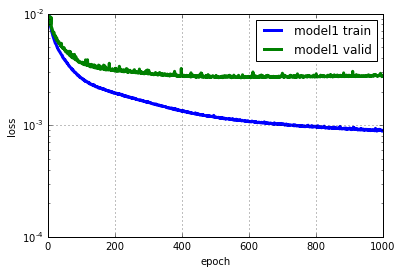

In [16]:
# 学習曲線をplot
from matplotlib import pyplot
% matplotlib inline
pyplot.plot(hist1.history['loss'], linewidth=3, label='model1 train')
pyplot.plot(hist1.history['val_loss'], linewidth=3, label='model1 valid')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale('log')
pyplot.show()

### ・学習したモデルを使ってkeypointsを出力

In [17]:
# test用データのload
# 関数load()は、X, yが出力されるので、いらないyは_で受ける
X_test, _ = load(test=True)
y_test = model.predict(X_test)

ImageId    1783
Image      1783
dtype: int64


In [18]:
def plot_sample(x, y, axis):
    # 顔データの整形
    img = x.reshape(96, 96)
    # numpy arrayをimageとして出力
    axis.imshow(img, cmap='gray')
    # keypointをプロット
    # array[XX:YY:ZZ]はXXからYYまでステップ幅ZZで成分を指定
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

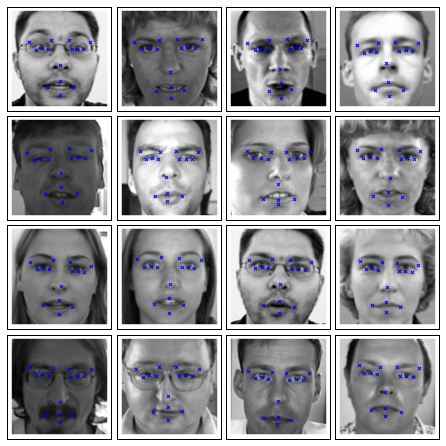

In [19]:
# keypointの出力
fig = pyplot.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    # subplot内に各々プロットをする
    # 4×4のsubplot内のi+1番目に出力
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

pyplot.show()

In [20]:
# 学習モデルの保存
json_string = model.to_json()
# モデルの構造説明のみをjson形式で保存
open('model1_architecture.json', 'w').write(json_string)
# weightの情報を保存
model.save_weights('model1_weights.h5', overwrite=True)

In [21]:
# 学習済みモデルの読み込み
from keras.models import model_from_json
model = model_from_json(open('model1_architecture.json').read())
model.load_weights('model1_weights.h5')

## モデル２：畳み込み

In [22]:
# 9216ピクセルの画像データを(1,92,92)のデータに変換
# 最初の1はチャネルをあらわす（グレースケールの場合は1だけ）
def load2d(test=False, cols=None):
    X, y = load(test, cols)
    # 4次元にする
    # -1を指定した次元は他の次元数から自動調整される
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [23]:
from keras.layers import Convolution2D, MaxPooling2D, Flatten

# 2Dデータ(train用)のload
X, y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [24]:
# Kerasモデルの設定
model2 = Sequential()

# 入力は96×96のピクセルデータ１枚
# 3×3のフィルターを32個用意して畳み込みすると、94×94が32枚できる
model2.add(Convolution2D(32, 3, 3, input_shape=(1, 96, 96)))
model2.add(Activation('relu'))
# 2×2の中で最大値を残すことで47×47が32枚できる
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 2×2のフィルターを2個用意して畳み込みすると、46×46が64枚できる
model2.add(Convolution2D(64, 2, 2))
model2.add(Activation('relu'))
# 2×2の中で最大値を残すことで23×23が64枚できる
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 2×2のフィルターを2個用意して畳み込みすると、22×22が128枚できる
model2.add(Convolution2D(128, 2, 2))
model2.add(Activation('relu'))
# 2×2の中で最大値を残すことで11×11が128枚できる
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 1次元に直すと11×11×128=15488成分
model2.add(Flatten())
# 500個の中間層とfull connected
model2.add(Dense(500))
model2.add(Activation('relu'))
# 500個の中間層とfull connected
model2.add(Dense(500))
model2.add(Activation('relu'))
# 出力は30個
model2.add(Dense(30))

In [25]:
# 確率的勾配法
sgd = SGD(lr='0.01', momentum=0.9, nesterov=True)
model2.compile(loss='mean_squared_error', optimizer=sgd)

# 学習
hist2 = model2.fit(X, y, nb_epoch=1000, validation_split=0.2, verbose=0)

In [26]:
# 学習モデルの保存
json_string2 = model2.to_json()
# モデルの構造説明のみをjson形式で保存
open('model2_architecture.json', 'w').write(json_string2)
# weightの情報を保存
model2.save_weights('model2_weights.h5', overwrite=True)

In [27]:
# モデルの構造を表示 !!!!pydotとpydot-ngが原因でエラーが出る!!!!
# from keras.utils.visualize_util import plot
# plot(model2, to_file='model2.png', show_shapes=True)

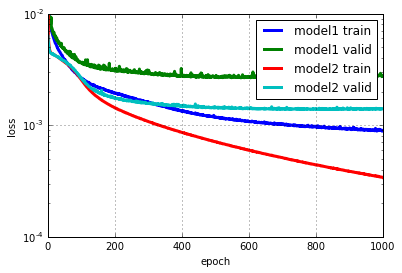

In [28]:
# 学習曲線をplot
pyplot.plot(hist1.history['loss'], linewidth=3, label='model1 train')
pyplot.plot(hist1.history['val_loss'], linewidth=3, label='model1 valid')
pyplot.plot(hist2.history['loss'], linewidth=3, label='model2 train')
pyplot.plot(hist2.history['val_loss'], linewidth=3, label='model2 valid')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale('log')
pyplot.show()

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


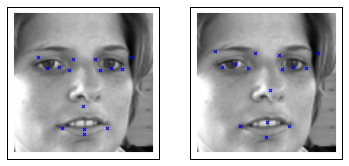

In [29]:
# model1とmode2でkeypointの出力
sample1 = load(test=True)[0][6:7]
sample2 = load2d(test=True)[0][6:7]
y_pred1 = model.predict(sample1)[0]
y_pred2 = model2.predict(sample2)[0]

fig = pyplot.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1, y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample2, y_pred2, ax)
pyplot.show()

## モデル３：Data Augmentation
### ・過学習を防ぐために水平反転した訓練データを追加する

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

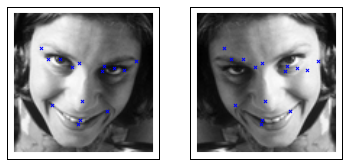

In [30]:
# 訓練データの水平反転
X, y = load2d()
X_flipped = X[:, :, :, ::-1]

# plot
# 訓練データだけを反転しているので教師データとのズレが生じる
fig = pyplot.figure(figsize=(6,3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X[1], y[1], ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(X_flipped[1], y[1], ax)
pyplot.show()

In [31]:
# 教師データのkeypointも反転させる
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
]
df = read_csv(os.path.expanduser(FTRAIN))
for i,j in flip_indices:
    print("{} -> {}".format(df.columns[i], df.columns[j]))

left_eye_center_x -> right_eye_center_x
left_eye_center_y -> right_eye_center_y
left_eye_inner_corner_x -> right_eye_inner_corner_x
left_eye_inner_corner_y -> right_eye_inner_corner_y
left_eye_outer_corner_x -> right_eye_outer_corner_x
left_eye_outer_corner_y -> right_eye_outer_corner_y
left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
mouth_left_corner_x -> mouth_right_corner_x
mouth_left_corner_y -> mouth_right_corner_y


In [32]:
# KerasのImageDataGeneratorクラスを継承して、
# Xとyを同時にflipするクラスを作成
from keras.preprocessing.image import ImageDataGenerator
class FlippedImageDataGenerator(ImageDataGenerator):
    
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
    ]
    
    def next(self):
        
        # 継承元クラスのnext関数を呼び出す
        X_batch, y_batch = super(FlippedImageDataGenerator, self).next()
        # データサイズの50%をランダムでflipする
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]
        
        # y_batchがある場合
        if y_batch is not None:
            # x座標をフリップ
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1
            
            # left_eye_center_x -> right_eye_center_xのようにフリップ
            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (y_batch[indices, b], y_batch[indices, a])
                
        return X_batch, y_batch


In [33]:
from sklearn.cross_validation import train_test_split

# データをロードしてtrain用とvalidation用にランダムに分ける
X, y = load2d()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# modelの設定
model3 = Sequential()

model3.add(Convolution2D(32, 3, 3, input_shape=(1, 96, 96)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Convolution2D(64, 2, 2))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Convolution2D(128, 2, 2))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(500))
model3.add(Activation('relu'))
model3.add(Dense(500))
model3.add(Activation('relu'))
model3.add(Dense(30))

# 確率的勾配法
sgd = SGD(lr='0.01', momentum=0.9, nesterov=True)
model3.compile(loss='mean_squared_error', optimizer=sgd)

# データの反転クラスのインスタンス生成
flipgen = FlippedImageDataGenerator()

# 学習
hist3 = model3.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=1000,
                             validation_data=(X_val, y_val), verbose=0)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [34]:
# 学習モデルの保存
json_string3 = model3.to_json()
# モデルの構造説明のみをjson形式で保存
open('model3_architecture.json', 'w').write(json_string3)
# weightの情報を保存
model3.save_weights('model3_weights.h5', overwrite=True)

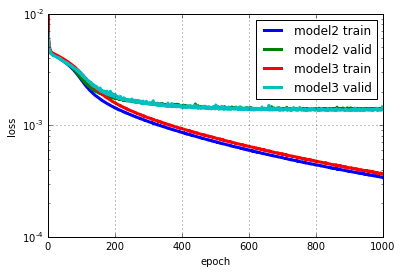

In [35]:
# 学習曲線をplot
pyplot.plot(hist2.history['loss'], linewidth=3, label='model2 train')
pyplot.plot(hist2.history['val_loss'], linewidth=3, label='model2 valid')
pyplot.plot(hist3.history['loss'], linewidth=3, label='model3 train')
pyplot.plot(hist3.history['val_loss'], linewidth=3, label='model3 valid')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale('log')
pyplot.show()

In [36]:
# 追加で2000epochを学習
model3_added = model3
model3_added.compile(loss='mean_squared_error', optimizer=sgd)
flipgen = FlippedImageDataGenerator()
hist3_added = model3_added.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=2000,
                             validation_data=(X_val, y_val), verbose=0)

In [37]:
# 学習モデルの保存
json_string3_added = model3_added.to_json()
# モデルの構造説明のみをjson形式で保存
open('model3_added_architecture.json', 'w').write(json_string3_added)
# weightの情報を保存
model3_added.save_weights('model3_added_weights.h5', overwrite=True)

## モデル４：学習係数の変更
### ・学習係数を最初は大きめ、最後は小さめにする

In [38]:
# モジュールのimport
from keras.callbacks import  LearningRateScheduler

In [39]:
# 最初と最後の学習係数を指定して、線形に変化させていく
# 最初は早めに学習して、最後は遅め
start = 0.03
stop = 0.001
nb_epoch = 1000

# startからstopまでnum分割の配列を返す
learning_rates = np.linspace(start, stop, nb_epoch)


In [41]:
# modelの設定
model4 = Sequential()

model4.add(Convolution2D(32, 3, 3, input_shape=(1, 96, 96)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Convolution2D(64, 2, 2))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Convolution2D(128, 2, 2))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten())
model4.add(Dense(500))
model4.add(Activation('relu'))
model4.add(Dense(500))
model4.add(Activation('relu'))
model4.add(Dense(30))

# LearningRateのスケジュールを設定
change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

# 確率的勾配法
sgd = SGD(lr=start, momentum=0.9, nesterov=True)
model4.compile(loss='mean_squared_error', optimizer=sgd)

# データの反転クラスのインスタンス生成
flipgen = FlippedImageDataGenerator()

# 学習
hist4 = model4.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=nb_epoch,
                             validation_data=(X_val, y_val),
                            callbacks=[change_lr], verbose=0)


In [42]:
# 学習モデルの保存
json_string4 = model4.to_json()
# モデルの構造説明のみをjson形式で保存
open('model4_architecture.json', 'w').write(json_string4)
# weightの情報を保存
model4.save_weights('model4_weights.h5', overwrite=True)

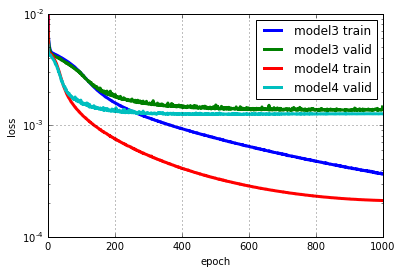

In [43]:
# 学習曲線をplot
pyplot.plot(hist3.history['loss'], linewidth=3, label='model3 train')
pyplot.plot(hist3.history['val_loss'], linewidth=3, label='model3 valid')
pyplot.plot(hist4.history['loss'], linewidth=3, label='model4 train')
pyplot.plot(hist4.history['val_loss'], linewidth=3, label='model4 valid')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale('log')
pyplot.show()

## モデル５：ドロップアウト
### ・過学習を防ぐためにrandomにニューロンを無視して学習する
### ・ドロップアウトの適用は学習時のみでテスト時には適用されない

In [44]:
# モジュールのimport
from keras.layers import Dropout

In [45]:
# 学習係数のパラメータ
start = 0.03
stop = 0.001
nb_epoch = 1000

# startからstopまでnum分割の配列を返す
learning_rates = np.linspace(start, stop, nb_epoch)

In [46]:
# データ準備
X, y = load2d()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [47]:
# modelの設定
model5 = Sequential()

model5.add(Convolution2D(32, 3, 3, input_shape=(1, 96, 96)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout
model5.add(Dropout(0.1))

model5.add(Convolution2D(64, 2, 2))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout
model5.add(Dropout(0.2))

model5.add(Convolution2D(128, 2, 2))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout
model5.add(Dropout(0.3))

model5.add(Flatten())
model5.add(Dense(500))
model5.add(Activation('relu'))
# Dropout
model5.add(Dropout(0.5))
model5.add(Dense(500))
model5.add(Activation('relu'))
model5.add(Dense(30))

# LearningRateのスケジュールを設定
change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

# 確率的勾配法
sgd = SGD(lr=start, momentum=0.9, nesterov=True)
model5.compile(loss='mean_squared_error', optimizer=sgd)

# データの反転クラスのインスタンス生成
flipgen = FlippedImageDataGenerator()

# 学習
hist5 = model5.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=nb_epoch,
                             validation_data=(X_val, y_val),
                            callbacks=[change_lr], verbose=0)


In [48]:
# 学習モデルの保存
json_string5 = model5.to_json()
# モデルの構造説明のみをjson形式で保存
open('model5_architecture.json', 'w').write(json_string5)
# weightの情報を保存
model5.save_weights('model5_weights.h5', overwrite=True)

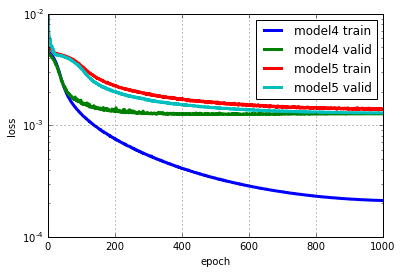

In [49]:
# 学習曲線をplot
pyplot.plot(hist4.history['loss'], linewidth=3, label='model4 train')
pyplot.plot(hist4.history['val_loss'], linewidth=3, label='model4 valid')
pyplot.plot(hist5.history['loss'], linewidth=3, label='model5 train')
pyplot.plot(hist5.history['val_loss'], linewidth=3, label='model5 valid')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale('log')
pyplot.show()

## train errorにはドロップアウトが含まれているが、validation errorにはドロップアウトが含まれていない

In [50]:
# ドロップアウトなしの状態でtrain errorを表示
# 単にtrain dataを使ってpredictする
from sklearn.metrics import  mean_squared_error
print('mean squared error', mean_squared_error(model5.predict(X), y))

mean squared error 0.00108576532859


## モデル６：全結合層のニューロン数を増やす
### ・ドロップアウトを使えば過学習を防げる

In [51]:
# 学習係数のパラメータ
start = 0.03
stop = 0.001
nb_epoch = 5000

# startからstopまでnum分割の配列を返す
learning_rates = np.linspace(start, stop, nb_epoch)

In [52]:
# modelの設定
model6 = Sequential()

model6.add(Convolution2D(32, 3, 3, input_shape=(1, 96, 96)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout
model6.add(Dropout(0.1))

model6.add(Convolution2D(64, 2, 2))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout
model6.add(Dropout(0.2))

model6.add(Convolution2D(128, 2, 2))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout
model6.add(Dropout(0.3))

model6.add(Flatten())
model6.add(Dense(1000))
model6.add(Activation('relu'))
# Dropout
model6.add(Dropout(0.5))
model6.add(Dense(1000))
model6.add(Activation('relu'))
model6.add(Dense(30))

# LearningRateのスケジュールを設定
change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

# 確率的勾配法
sgd = SGD(lr=start, momentum=0.9, nesterov=True)
model6.compile(loss='mean_squared_error', optimizer=sgd)

# データの反転クラスのインスタンス生成
flipgen = FlippedImageDataGenerator()

# 学習
hist6 = model6.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=nb_epoch,
                             validation_data=(X_val, y_val),
                            callbacks=[change_lr], verbose=0)


In [53]:
# 学習モデルの保存
json_string6 = model6.to_json()
# モデルの構造説明のみをjson形式で保存
open('model6_architecture.json', 'w').write(json_string6)
# weightの情報を保存
model6.save_weights('model6_weights.h5', overwrite=True)

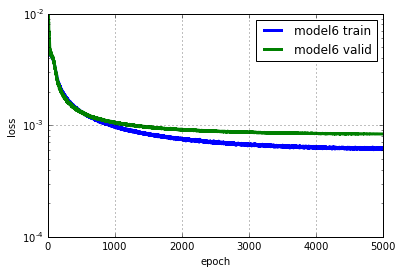

In [54]:
# 学習曲線をplot
pyplot.plot(hist6.history['loss'], linewidth=3, label='model6 train')
pyplot.plot(hist6.history['val_loss'], linewidth=3, label='model6 valid')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale('log')
pyplot.show()


## モデル７：Early Stopping
### ・validation errorが最小になった時点で学習をストップさせる

In [55]:
# モジュールのimport
from keras.callbacks import EarlyStopping

In [56]:
# early stop用のインスタンス生成
# 引数のpatienceは「何回連続でエラーの最小値が更新されなかったらストップするか」を表すパラメータ
early_stop = EarlyStopping(patience=100)

In [57]:
# 学習係数のパラメータ
start = 0.03
stop = 0.001
nb_epoch = 5000

# startからstopまでnum分割の配列を返す
learning_rates = np.linspace(start, stop, nb_epoch)

In [58]:
# modelの設定
model7 = Sequential()

model7.add(Convolution2D(32, 3, 3, input_shape=(1, 96, 96)))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout
model7.add(Dropout(0.1))

model7.add(Convolution2D(64, 2, 2))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout
model7.add(Dropout(0.2))

model7.add(Convolution2D(128, 2, 2))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout
model7.add(Dropout(0.3))

model7.add(Flatten())
model7.add(Dense(1000))
model7.add(Activation('relu'))
# Dropout
model7.add(Dropout(0.5))
model7.add(Dense(1000))
model7.add(Activation('relu'))
model7.add(Dense(30))

# LearningRateのスケジュールを設定
change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

# 確率的勾配法
sgd = SGD(lr=start, momentum=0.9, nesterov=True)
model7.compile(loss='mean_squared_error', optimizer=sgd)

# データの反転クラスのインスタンス生成
flipgen = FlippedImageDataGenerator()

# 学習
hist7 = model7.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=nb_epoch,
                             validation_data=(X_val, y_val),
                            callbacks=[change_lr, early_stop], verbose=0)


In [59]:
# 学習モデルの保存
json_string7 = model7.to_json()
# モデルの構造説明のみをjson形式で保存
open('model7_architecture.json', 'w').write(json_string7)
# weightの情報を保存
model7.save_weights('model7_weights.h5', overwrite=True)

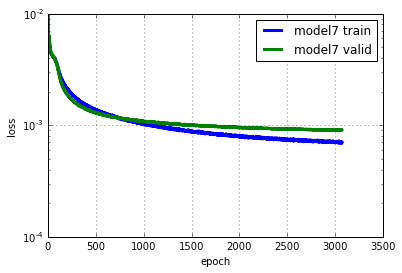

In [60]:
# 学習曲線をplot
pyplot.plot(hist7.history['loss'], linewidth=3, label='model7 train')
pyplot.plot(hist7.history['val_loss'], linewidth=3, label='model7 valid')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale('log')
pyplot.show()


## モデルの特化と転移学習
### ・これまでは、全てのkeypointデータが入力されているサンプルに限定して学習してきた
### ・これではサンプルの約70%を捨てていることになるので、一部のkeypointに限定したモデルにそれぞれ分けることでサンプルを有効に利用する
### ・全モデルを最初から学習するとかなり時間がかかるので、すでに学習した重みを初期値に設定する（転移学習）

In [73]:
# 6つのモデルに分けるためのdictionaryを作成
# 各モデルは有効サンプル数がだいたい同じぐらい存在する
SPECIALIST_SETTINGS = [
    
    dict(columns=('left_eye_center_x', 'left_eye_center_y',
                              'right_eye_center_x', 'right_eye_center_y',),
            flip_indices=((0,2), (1,3)),
            ),
    
    dict(columns=('nose_tip_x', 'nose_tip_y',),
            flip_indices=(),
            ),
    
    dict(columns=('mouth_left_corner_x', 'mouth_left_corner_y', 
                              'mouth_right_corner_x', 'mouth_right_corner_y',
                              'mouth_center_top_lip_x', 'mouth_center_top_lip_y'),
            flip_indices=((0,2), (1,3)),
            ),
    
    dict(columns=('mouth_center_bottom_lip_x', 
                              'mouth_center_bottom_lip_y',),
            flip_indices=(),
            ),

    dict(columns=('left_eye_inner_corner_x', 'left_eye_inner_corner_y', 
                              'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 
                              'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 
                              'right_eye_outer_corner_x', 'right_eye_outer_corner_y',),
            flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
            ),

    dict(columns=('left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 
                              'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 
                              'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 
                              'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',),
            flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
            ),
    
]

In [74]:
# モジュールのimport
from collections import OrderedDict

In [80]:
# モデルの特化用function
def fit_specialists(fname_pretrain=None):
    
    # 学習結果格納用
    specialists_model = OrderedDict()
    specialists_hist = OrderedDict()
    
    # 学習率の設定
    # 転移学習を行うので少し小さめからスタート
    start = 0.01
    stop = 0.001
    nb_epoch = 300
    
    # 6つのdictionary毎にloop
    for setting in SPECIALIST_SETTINGS:
        
        # 対象となるcolumnsを特定しデータをload
        cols = setting['columns']
        X, y = load2d(cols=cols)
        
        # train用、test用データに分割
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # model7(Early Stopping)のアーキテクチャを取得
        model8 = model_from_json(model7.to_json())
        
        # 転移学習の場合
        # 事前に学習した重みをloadする
        if fname_pretrain:
            model8.load_weights(fname_pretrain)
        
        # 出力層の次元を各モデルのKeypoint数に対応させる
        model8.layers.pop() # 出力層を取り除く
        model8.add(Dense(len(cols))) # 各モデルのKeypoint数に一致する出力層を追加
        
        # 確率的勾配法
        sgd = SGD(lr=start, momentum=0.9, nesterov=True)
        model8.compile(loss='mean_squared_error', optimizer=sgd)
        
        # モデルの構造を表示 !!!!pydotとpydot-ngが原因でエラーが出る!!!!
        # plot(model8, to_file='model8_{}.png'.format(cols[0]), show_shapes=True)
        
        # 水平反転データ作成
        flipgen = FlippedImageDataGenerator()
        flipgen.flip_indices = setting['flip_indices']
        
        # early stopping用の設定
        early_stop = EarlyStopping(patience=100)
        
        # 学習係数の設定
        learning_rates = np.linspace(start, stop, nb_epoch)
        change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
        
        print("Training model for columns {} for {} epochs".format(cols, nb_epoch))
        
        # 学習
        hist8 = model8.fit_generator(flipgen.flow(X_train, y_train),
                                    samples_per_epoch=X_train.shape[0],
                                    nb_epoch=nb_epoch,
                                    validation_data=(X_val, y_val),
                                    callbacks=[change_lr, early_stop], verbose=0)
        
        # 学習結果の格納
        specialists_model[cols] = model8
        specialists_hist[cols] = hist8
        
    return specialists_model, specialists_hist

In [81]:
# モデル特化＋転移学習の実行
# model6の重みを利用
model8, hist8 = fit_specialists('model6_weights.h5')

left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 300 epochs
nose_tip_x    7049
nose_tip_y    7049
Image         7049
dtype: int64
Training model for columns ('nose_tip_x', 'nose_tip_y') for 300 epochs
mouth_left_corner_x       2269
mouth_left_corner_y       2269
mouth_right_corner_x      2270
mouth_right_corner_y      2270
mouth_center_top_lip_x    2275
mouth_center_top_lip_y    2275
Image                     7049
dtype: int64
Training model for columns ('mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y') for 300 epochs
mouth_center_bottom_lip_x    7016
mouth_center_bottom_lip_y    7016
Image                        7049
dtype: int64
Training model for columns ('mouth_center_bottom

In [100]:
# 学習モデルの保存
for i in range(0, len(SPECIALIST_SETTINGS)-1):
    
    model_i = model8[SPECIALIST_SETTINGS[i]['columns']]
    json_string8_i = model_i.to_json()
    # モデルの構造説明のみをjson形式で保存
    open('model8_'+str(i+1)+'_architecture.json', 'w').write(json_string8_i)
    # weightの情報を保存
    model_i.save_weights('model8_'+str(i+1)+'_weights.h5', overwrite=True)

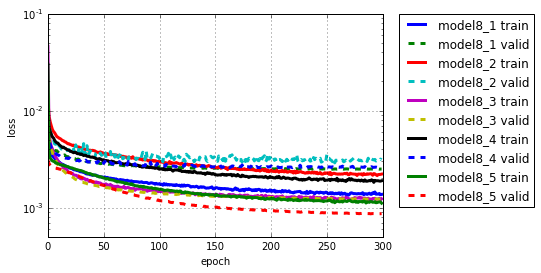

In [110]:
# 学習曲線をplot
for i in range(0, len(SPECIALIST_SETTINGS)-1):
    hist_i = hist8[SPECIALIST_SETTINGS[i]['columns']]
    pyplot.plot(hist_i.history['loss'], linewidth=3, label='model8_'+str(i+1)+' train')
    pyplot.plot(hist_i.history['val_loss'], '--', linewidth=3, label='model8_'+str(i+1)+' valid')

pyplot.grid()
pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.ylim(5e-4, 1e-1)
pyplot.yscale('log')
pyplot.show()
